In [33]:
%cd /home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST


/home1/giorgian/anaconda3/envs/jupyter/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [34]:
import torch
import pickle
import dataloaders
import matplotlib.pyplot as plt
from utils.log import load_checkpoint
from collections import defaultdict
from itertools import islice
from tqdm.notebook import tqdm
from models.Bipartite_Attention_Masked import Bipartite_Attention as Model
import matplotlib as mpl
import torch.nn as nn
import numpy as np
import random

In [35]:
from importlib import reload

{'batch_size': 64,
 'n_test': 5000,
 'n_train': 1,
 'n_valid': 49999,
 'n_workers': 16,
 'name': 'pred-tracks',
 'nontrigger_input_dir': '/ssd2/giorgian/hits-data-august-2022/nontrigger/0/',
 'rescale_by_percentile': -1,
 'trigger_input_dir': '/ssd3/giorgian/hits-data-october-2024/trigger/1/',
 'use_center': True,
 'use_energy': False,
 'use_geometric_features': True,
 'use_momentum': False,
 'use_n_hits': True,
 'use_n_pixels': False,
 'use_parallel_momentum': False,
 'use_predicted_pz': True,
 'use_radius': True,
 'use_transverse_momentum': False,
 'use_true_edges': True}

In [42]:
config_file_path = '/disks/disk1/giorgian/old-trainings/biatt-augment-adj/experiment_2023-06-13_10:12:01/config.pkl'
#config_file_path = 'train_results/biatt-augment-adj/experiment_2024-11-23_07:23:17/config.pkl'
config_file_path = '/disks/disk1/giorgian/old-trainings/biatt-augment-adj/experiment_2023-08-03_21:42:12/config.pkl'
with open(config_file_path, 'rb') as f:
    config = pickle.load(f)

In [44]:
dconfig = config['data']
#dconfig['trigger_input_dir'] = '/ssd3/giorgian/hits-data-march-2024/trigger/1/'
dconfig['n_valid'] += dconfig['n_train'] + dconfig['n_test']
dconfig['n_train'] = 1
dconfig['n_test'] = 1
train_data, val_data, test_data = dataloaders.get_data_loaders(**dconfig)


FileNotFoundError: [Errno 2] No such file or directory: '/ssd1/giorgian/data/alltrack/trigger/1'

In [ ]:
DEVICE = 'cuda:0'
# α=0.7
#checkpoint_file = 'train_results/biatt-augment-adj/experiment_2024-11-23_07:23:17/checkpoints/model_checkpoint_016.pth.tar'
checkpoint_file = '/disks/disk1/giorgian/old-trainings/biatt-augment-adj/experiment_2023-08-03_21:42:12/checkpoints/model_checkpoint_016.pth.tar'
mconfig = config['model']
model = Model(**mconfig)
model = load_checkpoint(checkpoint_file, model)
model = model.to(DEVICE)
model.eval()

In [39]:
def efficiency_purity(correct, preds_prob, signal_mix=0.01):
    signal = np.where(correct)[0]
    background = np.where(1 - correct)[0]
    mix = len(signal)/len(correct)
    drop = int(np.ceil((len(signal) - signal_mix * len(correct))/(1 - signal_mix)))
    np.random.shuffle(signal)
    keep = signal[:len(signal) - drop]
    keep = np.concatenate([keep, background], axis=0)
    c = correct[keep]
    p = preds_prob[keep]
    # Calculate efficiency
    tp = np.sum(c * (p > 0.5))
    tn = np.sum(( 1- c) * (p <= 0.5))
    fp = np.sum((1 - c) * (p > 0.5))
    fn = np.sum(c * (p <= 0.5))

    # effiency is how much of the signal we captured
    efficiency = tp/(tp + fn)
    # purity is how much of the signal is true
    purity = tp/(tp + fp)
    brr = tn/(tn + fp)

    return efficiency, purity, brr

def efficiency_purity_2(correct, preds_prob, signal_mix=0.01):
    signal = np.where(correct)[0]
    background = np.where(1 - correct)[0]
    mix = len(signal)/len(correct)
    drop = int(np.ceil((len(signal) - signal_mix * len(correct))/(1 - signal_mix)))

    np.random.shuffle(signal)
    keep = signal[:len(signal) - drop]
    keep = np.concatenate([keep, background], axis=0)
    c = correct[keep]
    print(f'{np.sum(c)/c.shape[0]=}')
    p = preds_prob[keep]
    # Calculate efficiency
    cutoffs = np.unique(p)
    efficiencies = []
    purities = []
    brrs = []
    for cutoff in tqdm(cutoffs):
        tp = np.sum(c * (p > cutoff))
        tn = np.sum(( 1- c) * (p <= cutoff))
        fp = np.sum((1 - c) * (p > cutoff))
        fn = np.sum(c * (p <= cutoff))

        # effiency is how much of the signal we captured
        efficiency = tp/(tp + fn) if tp + fp != 0 else 0
        # purity is how much of the signal is true
        purity = tp/(tp + fp) if tp + fp != 0 else 1
        brr = tn / (tn + fp) if tn + fp != 0 else 0

        efficiencies.append(efficiency)
        purities.append(purity)
        brrs.append(brr)
        
    return np.array(efficiencies), np.array(purities), np.array(brrs)

In [ ]:
dconfig

In [10]:
dconfig['load_complete_graph']

False

In [41]:
dconfig

{'batch_size': 64,
 'n_test': 1,
 'n_train': 1,
 'n_valid': 120000,
 'n_workers': 16,
 'name': 'pred-tracks',
 'nontrigger_input_dir': '/ssd3/giorgian/pred-tracks-october-2024/nontrigger/0/',
 'rescale_by_percentile': -1,
 'trigger_input_dir': '/ssd3/giorgian/pred-tracks-october-2024/trigger/1/',
 'use_center': True,
 'use_energy': False,
 'use_geometric_features': True,
 'use_momentum': False,
 'use_n_hits': True,
 'use_n_pixels': False,
 'use_parallel_momentum': False,
 'use_predicted_pz': True,
 'use_radius': True,
 'use_transverse_momentum': False,
 'use_true_edges': False}

In [40]:
N_BATCHES = 10000
preds = []
preds_prob = []
correct = []
val_data.dataset.dataset.phi = 0
for batch, mask in tqdm(val_data):
    mask = mask.to(DEVICE)
    track_vector = batch.track_vector.to(DEVICE)
    n_batches, n_tracks = track_vector.shape[:2]


    trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

    mask_logits = model(track_vector, mask)
    pred = mask_logits.max(dim=1)[1]
    preds.extend(pred.cpu().data.numpy())
    preds_prob.extend(nn.Softmax(dim=1)(mask_logits)[:, 1].detach().cpu().numpy().flatten())
    correct.extend(trigger.detach().cpu().numpy().flatten())

  0%|          | 0/3750 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f8bff5d1820>>
Traceback (most recent call last):
  File "/home1/giorgian/anaconda3/envs/jupyter/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [10]:
preds_prob = np.array(preds_prob)
preds = np.array(preds)
correct = np.array(correct)

In [11]:
accs_gt = np.sum(preds == correct, axis=-1)/correct.shape[0]
accs_gt

np.float64(0.992775)

In [12]:
efficiency_purity(correct, preds_prob, signal_mix=0.01)

(np.float64(0.990924092409241),
 np.float64(0.631440588853838),
 np.float64(0.9941583333333334))

In [13]:
efficiency_purity(correct, preds_prob, signal_mix=0.01)

(np.float64(0.9900990099009901),
 np.float64(0.631246712256707),
 np.float64(0.9941583333333334))

In [24]:
efficiencies, purities, brrs = efficiency_purity_2(correct, preds_prob, signal_mix=0.01)

np.sum(c)/c.shape[0]=np.float64(0.00999900999901)


  0%|          | 0/117220 [00:00<?, ?it/s]

In [15]:
for brr in [0.9, 0.95, 0.99, 0.999]:
    i = np.argmin(np.abs(brrs - brr))
    print(f'{efficiencies[i]*100:.2f}%, {purities[i]*100:.2f}%, {brrs[i]*100:.2f}%')

100.00%, 9.17%, 90.00%
100.00%, 16.81%, 95.00%
99.59%, 50.15%, 99.00%
97.94%, 90.82%, 99.90%


In [16]:
efficiencies, purities, brrs = efficiency_purity_2(correct, preds_prob, signal_mix=0.005)

np.sum(c)/c.shape[0]=np.float64(0.004999875624984453)


  0%|          | 0/116960 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Ground-Truth Track Efficiency/Purity Plot')

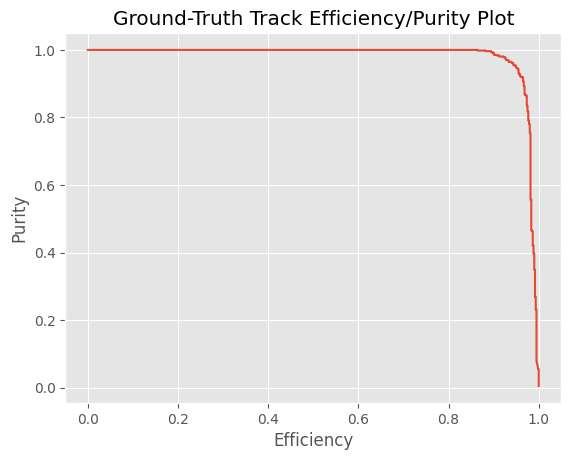

In [17]:
plt.style.use('ggplot')
plt.plot(efficiencies, purities)
plt.xlabel('Efficiency')
plt.ylabel('Purity')
plt.title('Ground-Truth Track Efficiency/Purity Plot')

Text(0.5, 1.0, 'Ground-Truth Track Efficiency/BRR Plot')

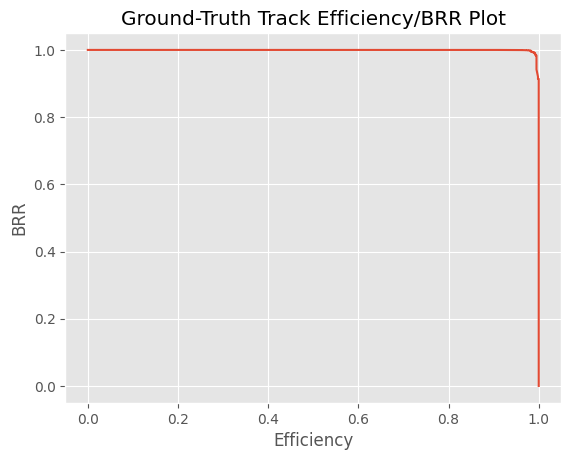

In [18]:
plt.style.use('ggplot')
plt.plot(efficiencies, brrs)
plt.xlabel('Efficiency')
plt.ylabel('BRR')
plt.title('Ground-Truth Track Efficiency/BRR Plot')

/tmp/ipykernel_4177645/3977552396.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(efficiencies, 1/(1 - brrs))


97.69%	90.80%	99.90%
100.00%	16.81%	95.00%


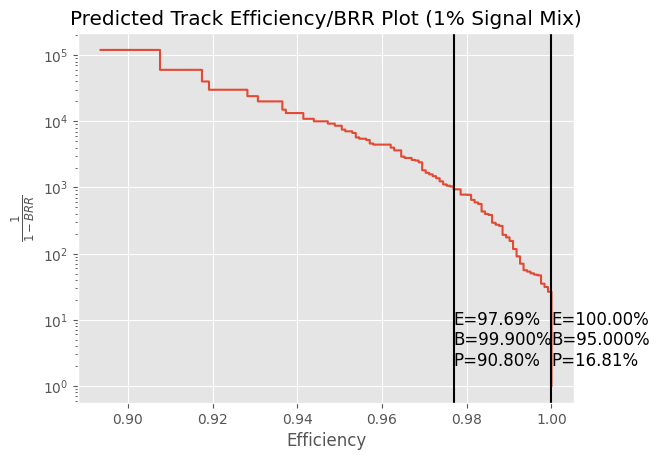

In [32]:
plt.style.use('ggplot')
plt.plot(efficiencies, 1/(1 - brrs))
plt.xlabel('Efficiency')
plt.ylabel('$\\frac{1}{1 - BRR}$')
plt.title('Predicted Track Efficiency/BRR Plot (1% Signal Mix)')
for brr in [0.999, 0.95]:
    i = np.argmin(np.abs(brrs - brr))
    x, y, p = efficiencies[i], brrs[i], purities[i]
    plt.axvline(x, color='black')
    plt.text(x, 2, f'E={x*100:.2f}%\nB={y*100:.3f}%\nP={p*100:.2f}%', fontsize=12)
    #plt.text(x, 0.1, f'=({x:.2f}, {y:.2f})', ha='right', va='bottom', fontsize=7)
    #plt.text(x, y, f'({x:.2f}, {y:.2f})', ha='right', va='bottom')
    print(f'{efficiencies[i]*100:.2f}%\t{purities[i]*100:.2f}%\t{brrs[i]*100:.2f}%')
plt.yscale('log')

In [94]:
np.sum(correct)*0.01

np.float64(550.0)

/tmp/ipykernel_2488268/734573361.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(efficiencies_1, 1/(1 - brrs_1))


100.00%	90.98%	99.90000000%
51.71%	99.65%	99.99818182%


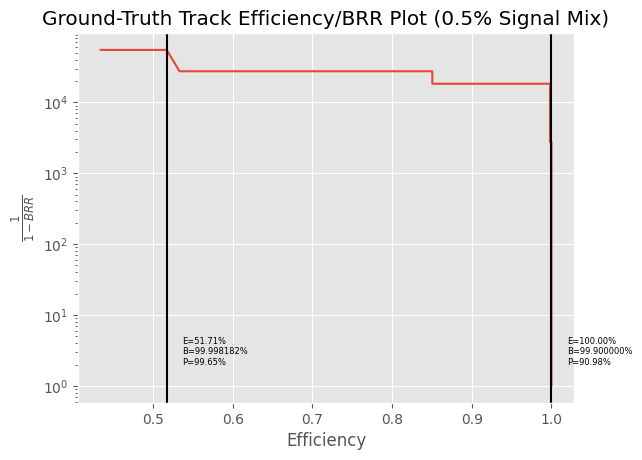

In [90]:
plt.style.use('ggplot')
plt.plot(efficiencies_1, 1/(1 - brrs_1))
plt.xlabel('Efficiency')
plt.ylabel('$\\frac{1}{1 - BRR}$')
plt.title('Ground-Truth Track Efficiency/BRR Plot (0.5% Signal Mix)')
for brr in [0.999, 0.99999]:
    i = np.argmin(np.abs(brrs_1 - brr))
    x, y, p = efficiencies_1[i], brrs_1[i], purities_1[i]
    plt.axvline(x, color='black')
    plt.text(x+0.02, 2, f'E={x*100:.2f}%\nB={y*100:.6f}%\nP={p*100:.2f}%', fontsize=6)
    #plt.text(x, 0.1, f'=({x:.2f}, {y:.2f})', ha='right', va='bottom', fontsize=7)
    #plt.text(x, y, f'({x:.2f}, {y:.2f})', ha='right', va='bottom')
    print(f'{efficiencies_1[i]*100:.2f}%\t{purities_1[i]*100:.2f}%\t{brrs_1[i]*100:.8f}%')
plt.yscale('log')

In [60]:
purities

array([0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615])

In [26]:
accs_pred_phi, accs_gt_phi

(array([0.86396484, 0.8625    , 0.86191406, 0.86191406, 0.85991211,
        0.86025391, 0.85908203, 0.85795898, 0.85771484, 0.85859375,
        0.85810547, 0.8574707 , 0.85649414, 0.85615234, 0.85541992,
        0.85595703, 0.85668945, 0.85678711, 0.85791016, 0.85888672,
        0.85869141, 0.85932617, 0.85927734, 0.85932617, 0.85854492,
        0.86015625, 0.85932617, 0.859375  , 0.85874023, 0.85849609,
        0.85927734, 0.85991211, 0.85961914, 0.86005859, 0.86015625,
        0.8609375 , 0.86079102, 0.86201172, 0.86254883, 0.86396484]),
 array([0.90356445, 0.90332031, 0.9034668 , 0.9019043 , 0.90019531,
        0.89829102, 0.89462891, 0.88847656, 0.878125  , 0.86557617,
        0.86103516, 0.87241211, 0.88481445, 0.89287109, 0.89785156,
        0.90019531, 0.90219727, 0.90219727, 0.9027832 , 0.90234375,
        0.9027832 , 0.9027832 , 0.90288086, 0.90239258, 0.90117187,
        0.89916992, 0.89375   , 0.88457031, 0.87290039, 0.86347656,
        0.86801758, 0.88217773, 0.89287109, 0.

In [ ]:
plt.plot(np.linspace(0, 2*np.pi, 40), accs_gt)
x_ticks = np.arange(0, (2 + 1/2)*np.pi, np.pi/2)
print(x_ticks)
ax = plt.gca()  # Get the current axis
ax.set_xticks(x_ticks)
ax.set_xticklabels(["0", "$\\frac{π}{2}$", "π", "$\\frac{3π}{2}$", "2π"])
plt.xlabel('Rotation Angle Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Rotation on Accuracy (GT Tracks)")

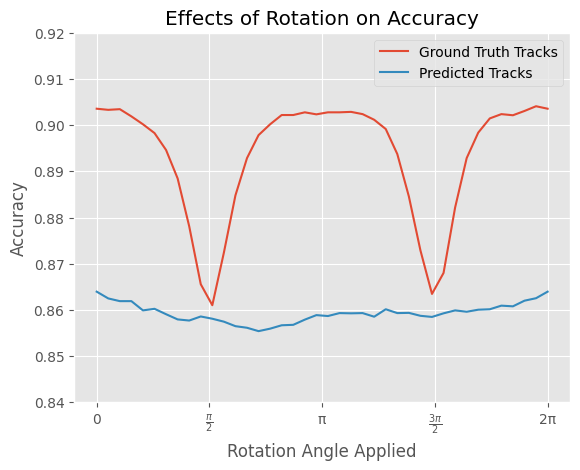

In [43]:
plt.style.use('ggplot')

plt.plot(np.linspace(0, 2*np.pi, 40), accs_gt_phi, label='Ground Truth Tracks')
plt.plot(np.linspace(0, 2*np.pi, 40), accs_pred_phi, label='Predicted Tracks')
x_ticks = np.arange(0, (2 + 1/2)*np.pi, np.pi/2)
ax = plt.gca()  # Get the current axis
ax.set_xticks(x_ticks)
ax.set_xticklabels(["0", "$\\frac{π}{2}$", "π", "$\\frac{3π}{2}$", "2π"])
plt.xlabel('Rotation Angle Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Rotation on Accuracy")
plt.ylim(0.84, 0.92)
plt.legend()

In [11]:
N_BATCHES = 1
all_preds = []
all_preds_prob = []
all_correct = []
val_data.dataset.dataset.phi = 0
for z in np.linspace(-20, 20, 10):
    preds = []
    preds_prob = []
    correct = []
    val_data.dataset.dataset.z = z
    for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
        mask = torch.zeros(batch.track_vector.shape[:-1])
        for i, n in enumerate(batch.n_tracks):
            mask[i, :n] = 1
            

        mask = mask.to(DEVICE)
        track_vector = batch.track_vector.to(DEVICE)
        n_batches, n_tracks = track_vector.shape[:2]
        hits = track_vector[:, :, :15].reshape(n_batches, n_tracks, 5, 3)
        
        
        is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
        trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

        mask_logits = model(track_vector, mask)
        pred = mask_logits.max(dim=1)[1]
        preds.extend(pred.cpu().data.numpy())
        preds_prob.extend(nn.Softmax(dim=1)(mask_logits)[:, 1].detach().cpu().numpy().flatten())
        correct.extend(trigger.detach().cpu().numpy().flatten())
    all_correct.append(correct)
    all_preds.append(preds)
    all_preds_prob.append(preds_prob)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Effects of Z Translation on Accuracy (GT Tracks)')

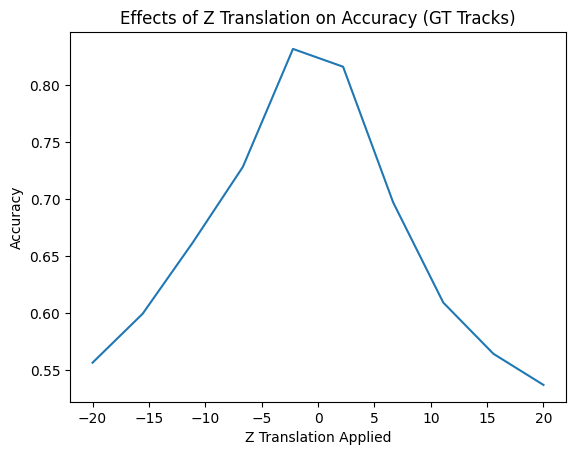

In [14]:
plt.plot(np.linspace(-20, 20, 10), accs_pred_z)
plt.xlabel('Z Translation Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Z Translation on Accuracy (GT Tracks)")

In [13]:
all_preds = np.array(all_preds)
all_correct = np.array(all_correct)
accs_pred_z = np.sum(all_preds == all_correct, axis=-1)/all_correct.shape[1]

Text(0.5, 1.0, 'Effects of Z Translation on Accuracy (GT Tracks)')

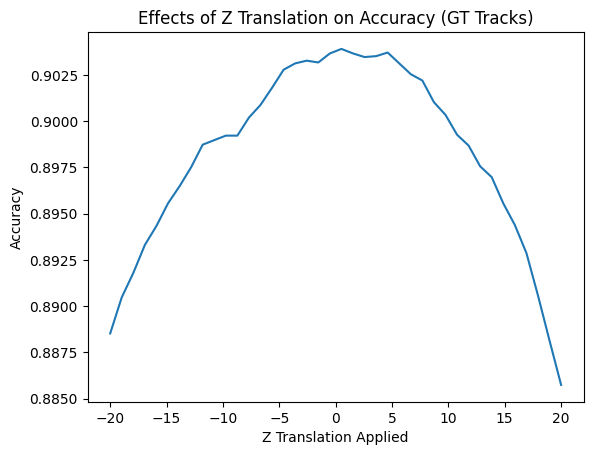

In [37]:
plt.plot(np.linspace(-20, 20, 40), accs_gt)
plt.xlabel('Z Translation Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Z Translation on Accuracy (GT Tracks)")

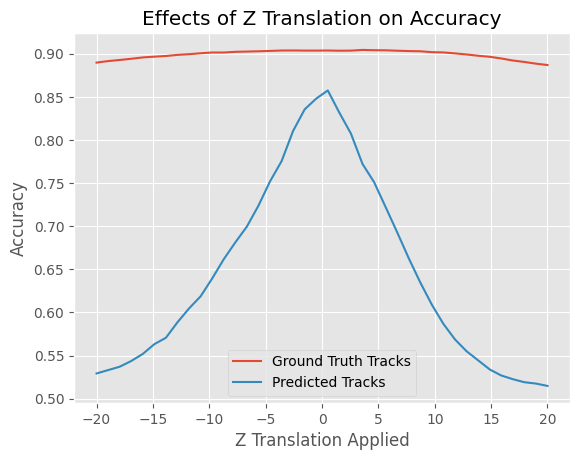

In [52]:
plt.style.use('ggplot')
plt.plot(np.linspace(-20, 20, 40), accs_gt_z, label='Ground Truth Tracks')
plt.plot(np.linspace(-20, 20, 40), accs_pred_z, label='Predicted Tracks')
plt.xlabel('Z Translation Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Z Translation on Accuracy")
plt.legend()

In [34]:
accs_gt_z, accs_pred_z

(array([0.88974609, 0.89150391, 0.89277344, 0.89418945, 0.89575195,
        0.89663086, 0.89741211, 0.89868164, 0.89951172, 0.90058594,
        0.90146484, 0.90141602, 0.90224609, 0.90253906, 0.90288086,
        0.90327148, 0.90375977, 0.90380859, 0.90366211, 0.90366211,
        0.90375977, 0.90351563, 0.90361328, 0.90444336, 0.90410156,
        0.90400391, 0.90351563, 0.903125  , 0.90288086, 0.90185547,
        0.90151367, 0.90043945, 0.89916992, 0.89770508, 0.89648438,
        0.89453125, 0.8921875 , 0.89047852, 0.88852539, 0.88691406]),
 array([0.53339844, 0.53847656, 0.5449707 , 0.55209961, 0.56079102,
        0.56977539, 0.58139648, 0.59355469, 0.60717773, 0.62148437,
        0.63842773, 0.65874023, 0.67739258, 0.70102539, 0.72509766,
        0.7527832 , 0.7824707 , 0.80791016, 0.83466797, 0.85678711,
        0.8609375 , 0.8418457 , 0.81318359, 0.78413086, 0.75449219,
        0.72202148, 0.69140625, 0.6625    , 0.63354492, 0.60693359,
        0.58305664, 0.56455078, 0.55170898, 0.

# Collect Statistics on Z-Distribution

In [47]:
N_BATCHES = 400
zs = []
val_data.dataset.dataset.phi = 0
val_data.dataset.dataset.z = 0


for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
    mask = torch.zeros(batch.track_vector.shape[:-1])
    for i, n in enumerate(batch.n_tracks):
        mask[i, :n] = 1

    mask = mask.to(DEVICE)
    track_vector = batch.track_vector.to(DEVICE)
    track_vector = track_vector * mask.unsqueeze(-1)
    n_batches, n_tracks = track_vector.shape[:2]
    hits = track_vector[:, :, :15].reshape(n_batches, n_tracks, 5, 3)
    good_hits = torch.any(hits != 0, dim=-1)
    zs.extend(hits[..., -1][good_hits].cpu().detach().numpy())

  0%|          | 0/400 [00:00<?, ?it/s]

In [39]:
gt_zs = np.array(zs)

In [48]:
pred_zs = np.array(zs)

Text(0.5, 1.0, 'Distribution of Z-Coordinate')

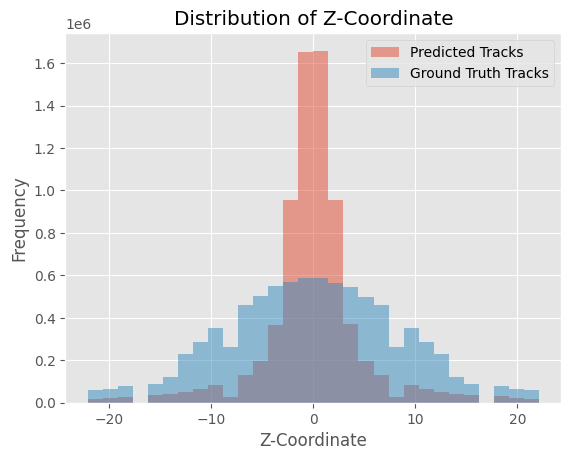

In [54]:
plt.style.use('ggplot')
plt.hist(pred_zs, bins=30, alpha=0.5, label='Predicted Tracks')
plt.hist(gt_zs, bins=30, alpha=0.5, label='Ground Truth Tracks')
plt.xlabel('Z-Coordinate')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Z-Coordinate')

In [49]:
help(plt.hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)
    Compute and plot a histogram.
    
    This method uses `numpy.histogram` to bin the data in *x* and count the
    number of values in each bin, then draws the distribution either as a
    `.BarContainer` or `.Polygon`. The *bins*, *range*, *density*, and
    *weights* parameters are forwarded to `numpy.histogram`.
    
    If the data has already been binned and counted, use `~.bar` or
    `~.stairs` to plot the distribution::
    
        counts, bins = np.histogram(x)
        plt.stairs(counts, bins)
    
    Alternatively, plot pre-computed bins and counts using ``hist()`` by
    treating each bin as a single point with a weight equal to its count::
    
        plt.hist(bins[:-1], bins, weights=coun

# Track Dropping

In [67]:
N_BATCHES = 80
# No dropping
all_preds = []
all_preds_prob = []
# Drop TT
tt_preds = []
tt_preds_prob = []
# Drop NT
nt_preds = []
nt_preds_prob = []

correct = []
val_data.dataset.dataset.phi = 0
val_data.dataset.dataset.z = 0

for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
    mask = torch.zeros(batch.track_vector.shape[:-1])
    nt_mask = torch.zeros(batch.track_vector.shape[:-1])
    for i, n in enumerate(batch.n_tracks):
        mask[i, :n] = 1
        nt_mask[i, :n] = 1
        n_trigger_tracks = torch.sum(batch.is_trigger_track[i].to(torch.bool))
        non_trigger_tracks = torch.where(~batch.is_trigger_track[i, :n].to(torch.bool))[0].numpy().tolist()
        #print(f'{non_trigger_tracks=}')
        random.shuffle(non_trigger_tracks)
        #print(f'{non_trigger_tracks=}')
        # We are randomly dropping the same amount of non-trigger tracks as of trigger tracks
        for j in non_trigger_tracks[:n_trigger_tracks]:
            #print(f'Setting {j} to 0')
            nt_mask[i, j] = 0
        #if n_trigger_tracks != 0:
           # print(f'{n_trigger_tracks=}\n{mask[i, :n]=}\n{nt_mask[i, :n]=}')
        

    mask = mask.to(DEVICE)
    nt_mask = nt_mask.to(DEVICE)
    track_vector = batch.track_vector.to(DEVICE)

    is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
    trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

    mask_logits = model(track_vector, mask)
    pred = mask_logits.max(dim=1)[1]
    all_preds.extend(pred[trigger.flatten()].cpu().numpy())
    all_preds_prob.extend(nn.Softmax(dim=1)(mask_logits[trigger.flatten()])[:, 1].detach().cpu().numpy().flatten())
    # Drop the trigger-tracks
    tt_mask = mask * ~is_trigger_track
    mask_logits = model(track_vector, tt_mask)
    tt_preds.extend(pred[trigger.flatten()].cpu().numpy())
    tt_preds_prob.extend(nn.Softmax(dim=1)(mask_logits[trigger.flatten()])[:, 1].detach().cpu().numpy().flatten())

    mask_logits = model(track_vector, nt_mask)
    nt_preds.extend(pred[trigger.flatten()].cpu().numpy())
    nt_preds_prob.extend(nn.Softmax(dim=1)(mask_logits[trigger.flatten()])[:, 1].detach().cpu().numpy().flatten())

    
    correct.extend(trigger.detach().cpu().numpy().flatten())



  0%|          | 0/80 [00:00<?, ?it/s]

In [58]:
all_pred = np.array(all_preds_prob)
all_pred_tt = np.array(tt_preds_prob)
all_pred_nt = np.array(nt_preds_prob)

In [68]:
all_gt = np.array(all_preds_prob)
all_gt_tt = np.array(tt_preds_prob)
all_gt_nt = np.array(nt_preds_prob)

In [59]:
len(all_pred)

20534

Text(0.5, 1.0, 'Effect of Track Dropping on Trigger Probability Distribution')

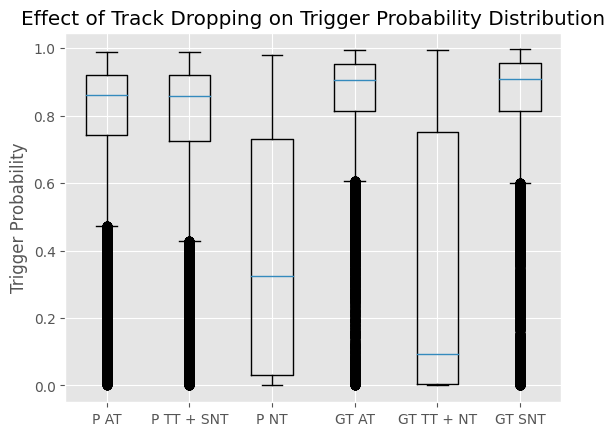

In [73]:
plt.style.use('ggplot')
plt.boxplot([all_pred, all_pred_nt, all_pred_tt, all_gt, all_gt_tt, all_gt_nt])
plt.xticks([1, 2, 3, 4, 5, 6], ['P AT', 'P TT + SNT', 'P NT', 'GT AT', 'GT TT + NT', 'GT SNT'])  # Adjust or add more labels based on your datasets
plt.ylabel('Trigger Probability')
plt.title('Effect of Track Dropping on Trigger Probability Distribution')

# Hit-Dropping

In [76]:
N_BATCHES = 80
# No dropping
pred_probs = [list() for i in range(5)]


val_data.dataset.dataset.phi = 0
val_data.dataset.dataset.z = 0

for layer_drop in range(5):
    for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
        mask = torch.zeros(batch.track_vector.shape[:-1])
        for i, n in enumerate(batch.n_tracks):
            mask[i, :n] = 1


        mask = mask.to(DEVICE)
        track_vector = batch.track_vector.to(DEVICE)
        n_batches, n_tracks = track_vector.shape[:2]
        hits = track_vector[..., :15].reshape(n_batches, n_tracks, 5, 3)
        hits[:, :, layer_drop, :] = 0
        track_vector[..., :15] = hits.reshape(n_batches, n_tracks, 15)

        is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
        trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

        mask_logits = model(track_vector, mask)
        pred = mask_logits.max(dim=1)[1]
        pred_probs[layer_drop].extend(nn.Softmax(dim=1)(mask_logits[trigger.flatten()])[:, 1].detach().cpu().numpy().flatten())
    


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0e34ad75b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0e244fa500>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0e441577c0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f0e244f9570>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0e244f9210>,
 'means': []}

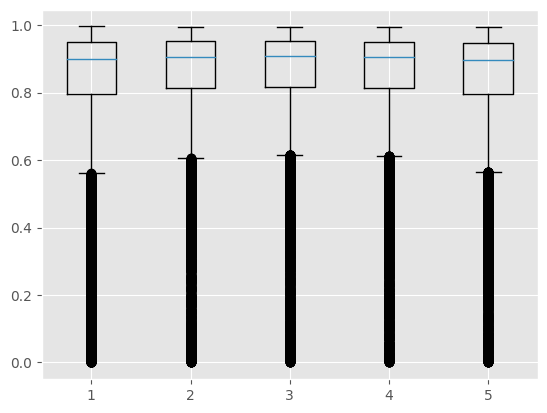

In [77]:
plt.boxplot(pred_probs)

# Noise Std

In [27]:
N_BATCHES = 40
all_preds = []
all_preds_prob = []
all_correct = []
val_data.dataset.dataset.phi = val_data.dataset.dataset.z = 0
noise_stds = np.linspace(-6, -1, 30)
#noise_stds = [-np.inf]
for noise_std in noise_stds:
    val_data.dataset.dataset.noise_std = 10**noise_std
    preds = []
    preds_prob = []
    correct = []
    for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
        mask = torch.zeros(batch.track_vector.shape[:-1])
        for i, n in enumerate(batch.n_tracks):
            mask[i, :n] = 1
            

        mask = mask.to(DEVICE)
        track_vector = batch.track_vector.to(DEVICE)
        n_batches, n_tracks = track_vector.shape[:2]
        hits = track_vector[:, :, :15].reshape(n_batches, n_tracks, 5, 3)
        
        
        is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
        trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

        mask_logits = model(track_vector, mask)
        pred = mask_logits.max(dim=1)[1]
        preds.extend(pred.cpu().data.numpy())
        preds_prob.extend(nn.Softmax(dim=1)(mask_logits)[:, 1].detach().cpu().numpy().flatten())
        correct.extend(trigger.detach().cpu().numpy().flatten())
    all_correct.append(correct)
    all_preds.append(preds)
    all_preds_prob.append(preds_prob)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [28]:
all_preds = np.array(all_preds)
all_correct = np.array(all_correct)
accs_gt_noise = np.sum(all_preds == all_correct, axis=-1)/all_correct.shape[1]

In [22]:
accs_gt_noise

array([0.86171875, 0.86171875, 0.86201172, 0.86123047, 0.8609375 ,
       0.86162109, 0.86054688, 0.86123047, 0.86147461, 0.85913086,
       0.85800781, 0.8550293 , 0.85263672, 0.84926758, 0.84204102,
       0.83647461, 0.82114258, 0.80473633, 0.78583984, 0.76347656,
       0.7418457 , 0.71289062, 0.68833008, 0.66591797, 0.65375977,
       0.63686523, 0.63540039, 0.63378906, 0.63691406, 0.64228516])

In [15]:
accs_pred_noise

array([0.86171875, 0.86171875, 0.86201172, 0.86123047, 0.8609375 ,
       0.86162109, 0.86054688, 0.86123047, 0.86147461, 0.85913086,
       0.85800781, 0.8550293 , 0.85263672, 0.84926758, 0.84204102,
       0.83647461, 0.82114258, 0.80473633, 0.78583984, 0.76347656,
       0.7418457 , 0.71289062, 0.68833008, 0.66591797, 0.65375977,
       0.63686523, 0.63540039, 0.63378906, 0.63691406, 0.64228516])

In [23]:
accs_gt_noise

array([0.90541992, 0.90537109, 0.90537109, 0.90541992, 0.90532227,
       0.90522461, 0.90512695, 0.90522461, 0.90493164, 0.90546875,
       0.90551758, 0.90463867, 0.90537109, 0.90395508, 0.90332031,
       0.90107422, 0.89135742, 0.87055664, 0.81494141, 0.715625  ,
       0.61269531, 0.54052734, 0.51552734, 0.50473633, 0.50180664,
       0.50058594, 0.49990234, 0.49985352, 0.49975586, 0.49951172])

In [12]:
accs_gt_noise, accs_pred_noise

NameError: name 'accs_gt_noise' is not defined

In [20]:
accs_gt_noise

array([0.86621094, 0.87011719, 0.84667969, 0.72949219, 0.66308594,
       0.64355469])

In [18]:
accs_pred_noise

array([0.86171875, 0.86171875, 0.86201172, 0.86123047, 0.8609375 ,
       0.86162109, 0.86054688, 0.86123047, 0.86147461, 0.85913086,
       0.85800781, 0.8550293 , 0.85263672, 0.84926758, 0.84204102,
       0.83647461, 0.82114258, 0.80473633, 0.78583984, 0.76347656,
       0.7418457 , 0.71289062, 0.68833008, 0.66591797, 0.65375977,
       0.63686523, 0.63540039, 0.63378906, 0.63691406, 0.64228516])

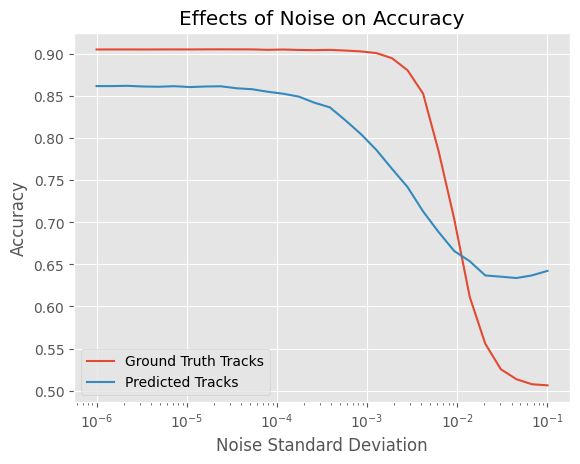

In [29]:
plt.style.use('ggplot')
plt.plot(10**noise_stds, accs_gt_noise, label='Ground Truth Tracks')
plt.plot(10**noise_stds, accs_pred_noise, label='Predicted Tracks')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.title("Effects of Noise on Accuracy")
plt.legend()